In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import linalg
from sklearn import preprocessing

## Load the MNIST data

In [2]:
import mnist

In [3]:
train_images,train_labels = mnist.read(range(0,10)) #load training set

In [4]:
def preprocess_mnist(images):
    """We are going to split the MNISt data to two halves, 
    we will return the right and left halves of flatten data"""
    left_images = np.zeros((images.shape[0],images.shape[1],images.shape[2]/2))
    right_images = np.zeros((images.shape[0],images.shape[1],images.shape[2]/2))
    
    for i in range(0,len(images)):
        left_images[i] = images[i][:,:14]
        right_images[i] = images[i][:,14:28]
    
    #convert images to image vector
    flatten_left = np.zeros((len(images),14*28))
    flatten_right = np.zeros((len(images),14*28))
    for i in range(0,len(images)):
        flatten_left[i] =left_images[i].flatten()
        flatten_right[i] =right_images[i].flatten()
    return flatten_left,flatten_right

In [5]:
training_left,training_right = preprocess_mnist(train_images)

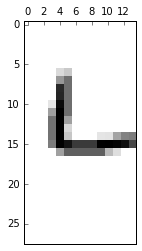

In [6]:
mnist.show(training_left[2].reshape((28,14)))

In [7]:
# Scale the data
left_scaler = preprocessing.StandardScaler()
right_scaler = preprocessing.StandardScaler()

In [8]:
scaled_left = left_scaler.fit_transform(training_left)
scaled_right = right_scaler.fit_transform(training_right)

## Perform CCA on left and right images

In [9]:
def qr_CCA(X,Y,n_components = 2):
    q1,r1 =linalg.qr(X)
    q2,r2 = linalg.qr(Y)
    
    U,s,Vh = linalg.svd(np.dot(q1.T,q2))
    
    a = np.dot(linalg.pinv(r1),U)
    b = np.dot(linalg.pinv(r2),Vh.T)
    #u = np.dot(q1,U[:,:n_components])
    #v = np.dot(q2,Vh.T[:,:n_components])
    return a,s,b,U,Vh.T

In [10]:
N = len(training_left) #number of samples to use

In [11]:
a,s,b,U,V = qr_CCA(scaled_left[0:N,:],scaled_right[0:N,:],n_components = 392)

# Reconstruction phase

We're gonna try reconstructing $y$ like this
$$ (x^T a^T)^{-1}Sb^{-1} = y $$

In [12]:
def qr_reconstruct(X,a,s,b,U,V):
    q,r = linalg.qr(X)
    u = np.dot(q,U)
    return np.dot(np.dot(linalg.pinv(u.T),np.diag(s)),linalg.pinv(b))

In [13]:
reconstructed_train_right = qr_reconstruct(scaled_left,a,s,b,U,V)

In [14]:
reconstructed_train_right = right_scaler.inverse_transform(reconstructed_train_right)

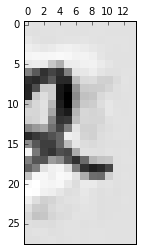

In [15]:
mnist.show(reconstructed_train_right[5].reshape((28,14)))

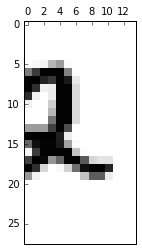

In [16]:
mnist.show(training_right[5].reshape((28,14)))

# Load testing data

In [17]:
test_images,test_labels = mnist.read(range(0,10),'testing') #load training set

In [18]:
test_left,test_right = preprocess_mnist(test_images)

In [19]:
# Scale the test data using train data
test_scaled_left = left_scaler.transform(test_left)
test_scaled_right = right_scaler.transform(test_right)

In [20]:
reconstructed_test_right = qr_reconstruct(test_scaled_left,a,s,b,U,V)
reconstructed_test_right = right_scaler.inverse_transform(reconstructed_test_right)

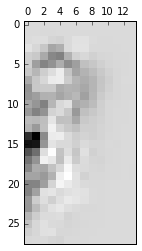

In [21]:
mnist.show(reconstructed_test_right[20].reshape((28,14)))

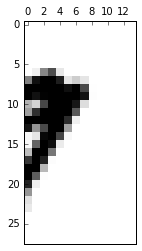

In [22]:
mnist.show(test_right[20].reshape((28,14)))

# Build a convnet

In [23]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [24]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [25]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [26]:
## First layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [27]:
## Second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [28]:
## Densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [29]:
## Dropout to the densely connected layer
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [30]:
## Readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [57]:
## Training and evaluating the model
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [58]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [40]:
batch_size = 100
iterations = 100

In [34]:
one_hot_labels = np.zeros((len(train_images),10))
one_hot_labels[np.arange(len(train_images)),train_labels.T.astype(int)] = 1

In [35]:
#convert images to image vector
flatten_train_images = np.zeros((len(train_images),28*28))
for i in range(0,len(train_images)):
    flatten_train_images[i] =train_images[i].flatten()

In [45]:
scaler = preprocessing.StandardScaler()
scaled_flatten_train_images = scaler.fit_transform(flatten_train_images)

In [52]:
indices = np.random.choice(len(train_images),batch_size)
x_batch = flatten_train_images[indices,:]

In [55]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [60]:
for i in range(iterations):
    indices = np.random.choice(len(train_images),batch_size)
    x_batch = scaled_flatten_train_images[indices,:]
    y_batch = one_hot_labels[indices]
    #batch = mnist_data.train.next_batch(50)
    #x_batch = batch[0]
    #y_batch = batch[1]
    if i%100 == 0:
        train_accuracy = sess.run(accuracy,feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        
    sess.run(train_step,feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})


step 0, training accuracy 0.83
step 100, training accuracy 0.03
step 200, training accuracy 0.06


KeyboardInterrupt: 

## Evaluate the model

In [38]:
flatten_test_images = np.zeros((len(test_images),28*28))
for i in range(0,len(test_images)):
    flatten_test_images[i] =test_images[i].flatten()
one_hot_labels_test = np.zeros((len(test_images),10))
one_hot_labels_test[np.arange(len(test_images)),test_labels.T.astype(int)] = 1

In [39]:
#print("test accuracy %g"%sess.run(accuracy,feed_dict={
    #x: flatten_test_images, y_: one_hot_labels_test, keep_prob: 1.0}))

IndentationError: unexpected indent (<ipython-input-39-cb44bd2fa68a>, line 2)

In [61]:
batch = mnist_data.train.next_batch(50)
x_batch = batch[0]
y_batch = batch[1]

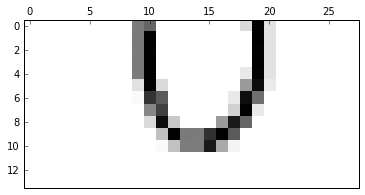

In [77]:
mnist.show(x_batch[49,14*28:].reshape((14,28)))

In [65]:
x_batch[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  